# Aspect Based Sentiment Analysis <a class="anchor" id="chapter1"></a>

### Table of Contents

* [Aspect Based Sentiment Analysis](#chapter1)
    * [Notes](#section_1_0)
    * [Importing Data & Libraries](#section_1_1)
    * [Feature Extraction](#section_1_2)
    * [Sentiment Analysis](#section_1_3)
        * [Shortcut to Read Joined Dataset](#section_1_3_1)
    * [Visualization](#section_1_4)

## Notes <a class="anchor" id="section_1_0"></a>

- Data Source : https://nijianmo.github.io/amazon/index.html

- Files $\Rightarrow$  Arts, Crafts and Sewing  $\Rightarrow$  "Review and Metadata" datasets must be downloaded as zip

- The notebook should be opened with Jupyter Lab, by this way the visualization part would be automatically shown up in new tab.

## Importing Data & Libraries <a class="anchor" id="section_1_1"></a>

In [1]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import gzip
import json
import spacy
from tqdm import tqdm
import re
import operator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
# To see whole sentences
pd.set_option("display.max_colwidth", -1)

In [4]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_review = getDF('C:/Users/Esra/Desktop/Aspect Based Sentiment Analysis - Amazon Review Dataset/Dataset/Arts_Crafts_and_Sewing.json.gz')
df_metadata = getDF('C:/Users/Esra/Desktop/Aspect Based Sentiment Analysis - Amazon Review Dataset/Dataset/meta_Arts_Crafts_and_Sewing.json.gz')

In [5]:
df_review = df_review.loc[:, ['asin', 'reviewText','summary','overall']]
df_review.head(5)

,asin,reviewText,summary,overall
0,0449819906,"I've read this book already and I've got plans for using it in future projects. I'm DELIGHTED with the patterns in it and the advice and suggestions are just as good as you would expect from Melissa Leapman. I'm so glad that I bought this. As a lifelong and addicted knitter, this has been a valuable addition to my already good sized book collection. Thanks Melissa for this very special knitting treat.",A WONDERFUL BOOK,5.0
1,0449819906,Nicely written directions.,Nice,5.0
2,0449819906,love it,Five Stars,5.0
3,0449819906,"Good additional knitting reference to have available in an electronic format. I like that it is easy to jump from one bit of information to another, since I was not sure if all the links to topics would be available in a Kindle format.",Good Reference in Kindle Edition,5.0
4,0449819906,"A gazillion pattern stitches, lucidly explained. Illustrations for each one on the same page as its instructions. A very thorough guide to basic techniques in an appendix. You won't get full patterns here, but the stitches are easily adapted to straightforward knitting projects on both straight and circular needles. A very useful book.","Extremely clear, thorough",5.0


In [6]:
df_metadata= df_metadata.loc[:,['title','asin']]
df_metadata.head(5)

,title,asin
0,You Son of a Bitch! 1987 Embroidered Patch,6665560953
1,Origami Stars Papers Package 1H (5 packs),7000000376
2,Yi De Ge Chinese Calligraphy Sumi Drawing Black Liquid Ink (black),7000001089
3,"10 pcs/Lot GITD Skeleton Skull ,Knife/ Flashlight/ Paracord Bracelet Accessories (N02)",7107269291
4,"Pinkie Tm girl flower Handmade soap silicone mold ,silica gel mould,silicon candle moulds,gift favor",7121277158


In [7]:
# Printing lengths of datasets
print('Review Dataset:', len(df_review), '| ', 'Meta dataset:', len(df_metadata))

Review Dataset: 2875917 |  Meta dataset: 302988


In [8]:
# Joining dataset in order to find product title
df_joined_dataset = pd.merge(df_review, df_metadata, on="asin")

In [9]:
df_joined_dataset

,asin,reviewText,summary,overall,title
0,6665560953,"Great quality product, and top notch service from the seller!",Five Stars,5.0,You Son of a Bitch! 1987 Embroidered Patch
1,6665560953,"details on this patch are very good, def a fav gift for the recipient. Would love if they offered a hook & loop option, but won't hold that against the quality of the product.",don't push too many pencils,5.0,You Son of a Bitch! 1987 Embroidered Patch
2,6665560953,Bought these as a gifts for friends and really impressed with the quality and speed of delivery! I recommend these patches for sure! I picked up 10 of these and plan to share it out. If you buy in the US watch shipping cost. But worth it if you buy in bulk!,Great deal if you buy in bulk!,5.0,You Son of a Bitch! 1987 Embroidered Patch
3,6665560953,"The photo's really didn't do this patch justice. It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment from PREDATOR, but this one was much, much, better than anything I saw on ETSY. It arrived looking great!",It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment ...,5.0,You Son of a Bitch! 1987 Embroidered Patch
4,6665560953,Exactly as pictured. My brother loves Predator so I had to get us matching patches!,CIA got you pushing too many pencils?,5.0,You Son of a Bitch! 1987 Embroidered Patch
...,...,...,...,...,...
2902716,B01HJGIR3E,"If you are a crafter or like decorating your home, you can't go wrong with this purchase! So many uses!!!!!",Beautiful sturdy ribbon! So many uses!!!!,5.0,"Creative Ideas 3&quot; Inch Solid Grosgrain Ribbon, 25 Yards, Pink, 25 yd"
2902717,B01HJGIR3E,"This ribbon was ridged, so I couldn't use it for my project. I needed smooth to attach letters.",Ridged ribbon,2.0,"Creative Ideas 3&quot; Inch Solid Grosgrain Ribbon, 25 Yards, Pink, 25 yd"
2902718,B01HJGIR3E,Very pretty ribbon. Good quality and good price.,Very pretty ribbon. Good quality and good price,5.0,"Creative Ideas 3&quot; Inch Solid Grosgrain Ribbon, 25 Yards, Pink, 25 yd"
2902719,B01HJGIR3E,"High quality ribbon, very wide.",Pink grosgrain ribbon,5.0,"Creative Ideas 3&quot; Inch Solid Grosgrain Ribbon, 25 Yards, Pink, 25 yd"


## Feature Extraction <a class="anchor" id="section_1_2"></a>


In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
# Due to speed of processing only a part of data was included.
df_joined_dataset = df_joined_dataset.iloc[0:5000,:]

aspect_terms = []
comp_terms = []
for x in tqdm(range(len(df_joined_dataset))):
    amod_pairs = []
    advmod_pairs = []
    compound_pairs = []
    xcomp_pairs = []
    neg_pairs = []
    if len(str(df_joined_dataset['reviewText'][x])) != 0:
        lines = str(df_joined_dataset['reviewText'][x]).split('.')       
        for line in lines:
            doc = nlp(line)
            str1=''
            str2=''
            for token in doc:
                if token.pos_ == 'NOUN':
                    for j in token.lefts:
                        if j.dep_ == 'compound':
                            compound_pairs.append((j.text+' '+token.text,token.text))
                        if j.dep_ == 'amod' and j.pos_ == 'ADJ': #primary condition
                            str1 = j.text+' '+token.text
                            amod_pairs.append(j.text+' '+token.text)
                            for k in j.lefts:
                                if k.dep_ == 'advmod': #secondary condition to get adjective of adjectives
                                    str2 = k.text+' '+j.text+' '+token.text
                                    amod_pairs.append(k.text+' '+j.text+' '+token.text)
                            mtch = re.search(re.escape(str1),re.escape(str2))
                            if mtch is not None:
                                amod_pairs.remove(str1)
                if token.pos_ == 'VERB':
                    for j in token.lefts:
                        if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                            advmod_pairs.append(j.text+' '+token.text)
                        if j.dep_ == 'neg' and j.pos_ == 'ADV':
                            neg_pairs.append(j.text+' '+token.text)
                    for j in token.rights:
                        if j.dep_ == 'advmod'and j.pos_ == 'ADV':
                            advmod_pairs.append(token.text+' '+j.text)
                if token.pos_ == 'ADJ':
                    for j,h in zip(token.rights,token.lefts):
                        if j.dep_ == 'xcomp' and h.dep_ != 'neg':
                            for k in j.lefts:
                                if k.dep_ == 'aux':
                                    xcomp_pairs.append(token.text+' '+k.text+' '+j.text)
                        elif j.dep_ == 'xcomp' and h.dep_ == 'neg':
                            if k.dep_ == 'aux':
                                    neg_pairs.append(h.text +' '+token.text+' '+k.text+' '+j.text)
        pairs = list(set(amod_pairs+advmod_pairs+neg_pairs+xcomp_pairs))
        for i in range(len(pairs)):
            if len(compound_pairs)!=0:
                for comp in compound_pairs:
                    mtch = re.search(re.escape(comp[1]),re.escape(pairs[i]))
                    if mtch is not None:
                        pairs[i] = pairs[i].replace(mtch.group(),comp[0])            
    aspect_terms.append(pairs)
    comp_terms.append(compound_pairs)

df_joined_dataset['compound_nouns'] = comp_terms
df_joined_dataset['aspect_keywords'] = aspect_terms
df_joined_dataset.head()

100%|██████████| 5000/5000 [02:59<00:00, 27.80it/s]


,asin,reviewText,summary,overall,title,compound_nouns,aspect_keywords
0,6665560953,"Great quality product, and top notch service from the seller!",Five Stars,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(quality product, product), (notch service, service)]","[Great quality product, top notch service]"
1,6665560953,"details on this patch are very good, def a fav gift for the recipient. Would love if they offered a hook & loop option, but won't hold that against the quality of the product.",don't push too many pencils,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(fav gift, gift)]",[]
2,6665560953,Bought these as a gifts for friends and really impressed with the quality and speed of delivery! I recommend these patches for sure! I picked up 10 of these and plan to share it out. If you buy in the US watch shipping cost. But worth it if you buy in bulk!,Great deal if you buy in bulk!,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(US cost, cost), (watch cost, cost), (shipping cost, cost)]",[]
3,6665560953,"The photo's really didn't do this patch justice. It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment from PREDATOR, but this one was much, much, better than anything I saw on ETSY. It arrived looking great!",It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment ...,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(patch justice, justice)]","[similar patches, other patches]"
4,6665560953,Exactly as pictured. My brother loves Predator so I had to get us matching patches!,CIA got you pushing too many pencils?,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(matching patches, patches)]",[Exactly pictured]


## Sentiment Analysis<a class="anchor" id="section_1_3"></a>

In [12]:
analyser = SentimentIntensityAnalyzer()

sentiment = []
max_aspect_word = []
for i in range(len(df_joined_dataset)):
    score_dict={'pos':0,'neg':0,'neu':0}
    if len(df_joined_dataset['aspect_keywords'][i])!=0: 
        for aspects in df_joined_dataset['aspect_keywords'][i]:
            sent = analyser.polarity_scores(aspects)
            score_dict['neg'] += sent['neg']
            score_dict['pos'] += sent['pos']
            score_dict['neu'] += sent['neu']
        max_aspect_word.append(aspects)
        sentiment.append(max(score_dict.items(), key=operator.itemgetter(1))[0])
    else:
        sentiment.append(None)
        max_aspect_word.append(None)

df_joined_dataset['max_aspect_word'] = max_aspect_word
df_joined_dataset['sentiment'] = sentiment
df_joined_dataset.head()

,asin,reviewText,summary,overall,title,compound_nouns,aspect_keywords,max_aspect_word,sentiment
0,6665560953,"Great quality product, and top notch service from the seller!",Five Stars,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(quality product, product), (notch service, service)]","[Great quality product, top notch service]",top notch service,pos
1,6665560953,"details on this patch are very good, def a fav gift for the recipient. Would love if they offered a hook & loop option, but won't hold that against the quality of the product.",don't push too many pencils,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(fav gift, gift)]",[],None,None
2,6665560953,Bought these as a gifts for friends and really impressed with the quality and speed of delivery! I recommend these patches for sure! I picked up 10 of these and plan to share it out. If you buy in the US watch shipping cost. But worth it if you buy in bulk!,Great deal if you buy in bulk!,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(US cost, cost), (watch cost, cost), (shipping cost, cost)]",[],None,None
3,6665560953,"The photo's really didn't do this patch justice. It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment from PREDATOR, but this one was much, much, better than anything I saw on ETSY. It arrived looking great!",It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment ...,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(patch justice, justice)]","[similar patches, other patches]",other patches,neu
4,6665560953,Exactly as pictured. My brother loves Predator so I had to get us matching patches!,CIA got you pushing too many pencils?,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(matching patches, patches)]",[Exactly pictured],Exactly pictured,neu


In [13]:
df_joined_dataset = df_joined_dataset[df_joined_dataset['sentiment'].notna()]

In [14]:
df_joined_dataset

,asin,reviewText,summary,overall,title,compound_nouns,aspect_keywords,max_aspect_word,sentiment
0,6665560953,"Great quality product, and top notch service from the seller!",Five Stars,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(quality product, product), (notch service, service)]","[Great quality product, top notch service]",top notch service,pos
3,6665560953,"The photo's really didn't do this patch justice. It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment from PREDATOR, but this one was much, much, better than anything I saw on ETSY. It arrived looking great!",It's made extremely well and looks GREAT! I've seen other similar patches depicting this moment ...,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(patch justice, justice)]","[similar patches, other patches]",other patches,neu
4,6665560953,Exactly as pictured. My brother loves Predator so I had to get us matching patches!,CIA got you pushing too many pencils?,5.0,You Son of a Bitch! 1987 Embroidered Patch,"[(matching patches, patches)]",[Exactly pictured],Exactly pictured,neu
5,6665560953,"Really great quality work on the patch just would of like instructions on the best way to attach to a cap,shirt, etc.",Really great quality work on the patch just would of like ...,4.0,You Son of a Bitch! 1987 Embroidered Patch,"[(quality work, work)]","[Really great quality work, just would, great quality work, best way]",best way,pos
6,6665560953,"This patch is awesome, ended up getting some adhesive backed Velcro and they stuck together well. Stuck this on my backpack. I've gotten several comments both from people that get the reference to the 1987 Movie and people that just like the look of it. Appears well made and clear, slightly darker then picture.","Awesome patch, Nostalgic",5.0,You Son of a Bitch! 1987 Embroidered Patch,[],"[stuck well, well made, several comments, stuck together]",stuck together,neu
...,...,...,...,...,...,...,...,...,...
4993,B0000302YN,"Basic drill to engrave items. Only thing is it's LOUD and vibrates. It goes the job and comes with a small plate to follow the letters and numbers to make it look professional. VERY easy to use!\n\nPut the tip on, set to how deep you want to go and plug it in, turn on and away you go!\n\nGreat to protect items from theft so nobody can say it's not yours! Put the last four #s of your SSN, or last name, initials, or anything relating to you to engrave.",Basic Engraver,4.0,"Dremel 290-01 0.2 Amp 7,200 Stroke Per Minute Engraver includes Letter and Number Template",[],"[Only thing, small plate, deep want, last name, away go, Basic drill, easy to use]",easy to use,neu
4994,B0000302YN,"Basic drill to engrave items. Only thing is it's LOUD and vibrates. It goes the job and comes with a small plate to follow the letters and numbers to make it look professional. VERY easy to use!\n\nPut the tip on, set to how deep you want to go and plug it in, turn on and away you go!\n\nGreat to protect items from theft so nobody can say it's not yours! Put the last four #s of your SSN, or last name, initials, or anything relating to you to engrave.",Basic Engraver,4.0,"Dremel 290-01 0.2 Amp 7,200 Stroke Per Minute Engraver includes Letter and Number Template",[],"[Only thing, small plate, deep want, last name, away go, Basic drill, easy to use]",easy to use,neu
4995,B0000302YN,"very nice little tool for engraving on almost anything. It is a bit loud, but does a good job.",Dremel engraver,4.0,"Dremel 290-01 0.2 Amp 7,200 Stroke Per Minute Engraver includes Letter and Number Template",[],"[very nice tool, good job, little tool, nice tool]",nice tool,pos
4996,B0000302YN,"very nice little tool for engraving on almost anything. It is a bit loud, but does a good job.",Dremel engraver,4.0,"Dremel 290-01 0.2 Amp 7,200 Stroke Per Minute Engraver includes Letter and Number Template",[],"[very nice tool, good job, little tool, nice tool]",nice tool,pos


In [15]:
result = df_joined_dataset.groupby(['asin','title','max_aspect_word','sentiment']).count().sort_values(by = "aspect_keywords",ascending="False").reset_index()
result

,asin,title,max_aspect_word,sentiment,reviewText,summary,overall,compound_nouns,aspect_keywords
0,6665560953,You Son of a Bitch! 1987 Embroidered Patch,Exactly pictured,neu,1,1,1,1,1
1,8862933185,"Moleskine Passion Journal Hard Cover Notebook, Wellness, Large (5&quot; x 8.25&quot;) - Passion Journal for Wellness Journaling, Wellness Book with Tab Organization, Track Healthy Lifestyle Goals",small version,neu,1,1,1,1,1
2,8862933185,"Moleskine Passion Journal Hard Cover Notebook, Wellness, Large (5&quot; x 8.25&quot;) - Passion Journal for Wellness Journaling, Wellness Book with Tab Organization, Track Healthy Lifestyle Goals",small to fit,neu,1,1,1,1,1
3,8862933185,"Moleskine Passion Journal Hard Cover Notebook, Wellness, Large (5&quot; x 8.25&quot;) - Passion Journal for Wellness Journaling, Wellness Book with Tab Organization, Track Healthy Lifestyle Goals",small drawings,neu,1,1,1,1,1
4,8862933185,"Moleskine Passion Journal Hard Cover Notebook, Wellness, Large (5&quot; x 8.25&quot;) - Passion Journal for Wellness Journaling, Wellness Book with Tab Organization, Track Healthy Lifestyle Goals",running soon,neu,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
1980,B00002N6GB,"Jen Manufacturing Inc. Poly Foam Brush, 2 Inch (Pack of 48)",fall apart,neu,8,8,8,8,8
1981,B00000J3LY,"HP C6049A Iron-On Transfers, 8-1/2 x 11, White (Pack of 12)",used before,neu,10,10,10,10,10
1982,B0000302YN,"Dremel 290-01 0.2 Amp 7,200 Stroke Per Minute Engraver includes Letter and Number Template",Good product,pos,10,10,10,10,10
1983,B00002N6GB,"Jen Manufacturing Inc. Poly Foam Brush, 2 Inch (Pack of 48)",good quality,pos,10,10,10,10,10


### Shortcut to Read Joined Dataset <a class="anchor" id="section_1_3_1"></a>

We can directly upload preprocessed dataset to see the graphs.

In [18]:
# Here I exported the result df as csv in order to use in visualization step independently of previous steps and main dataset
result.to_csv('joined_dataset.csv')

# The exported csv can be uploaded in this step using our own path
result = pd.read_csv('joined_dataset.csv')

## Visualisation<a class="anchor" id="section_1_4"></a>

In [21]:
import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

pd.options.plotting.backend = "plotly"
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Aspect Based Sentiment Analysis from Product Reviews"),
    html.P(children='''Product Title'''),
    dcc.Dropdown(
        id='title', 
        options=[{'value': x, 'label': x} 
                 for x in [i for i in result.title.unique()]],
        value = "Jacquard Funky Groovy Tie Dye Kit",
        placeholder="Select a product title",
        clearable=False
    ),
     html.P("Aspect"),
    dcc.Dropdown(
        id='aspect', 
        value='pos', 
        options=[{'value': x, 'label': x} 
                 for x in ['pos', 'neg', 'neu']],
        clearable=False
    ),
    dcc.Graph(id="pie-chart"),
])

@app.callback(
    Output("pie-chart", "figure"), 
    [dash.dependencies.Input('title', 'value'), dash.dependencies.Input('aspect', 'value')])

def generate_chart(value, aspect):
    df = result[(result['title'] == str(value)) & (result['sentiment'] == str(aspect))].sort_values(by = "aspect_keywords",ascending="False").head(15)
    fig = px.pie(df,  names='max_aspect_word', values= 'aspect_keywords')
    return fig

# If a port is in use then it can be changed as we want.
app.run_server(mode='jupyterlab', port = 8190, dev_tools_ui=True, dev_tools_hot_reload =True, threaded=True)

**Sample screenshot from dashboard**

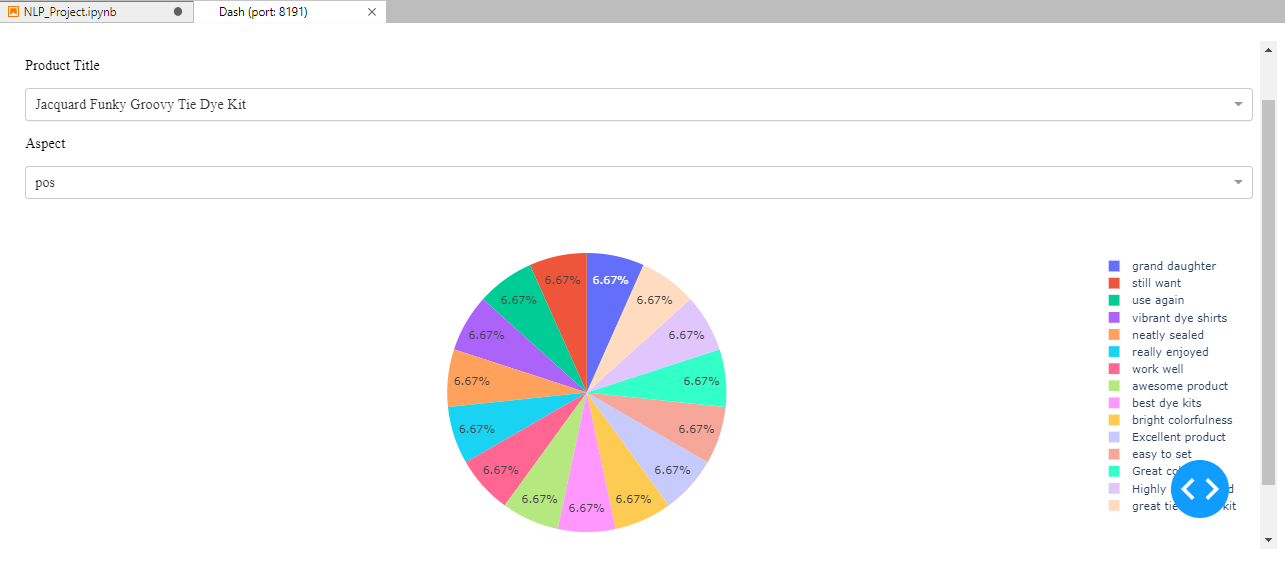